In [ ]:
#Computação científica
import numpy as np

#análise de dados
import pandas as pd

#machine learning
from sklearn.linear_model import LogisticRegression
#from sklearn.model_selection import GridSearchCV, KFold
import lightgbm as lgb


#mtricas
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

from sklearn.model_selection import train_test_split

#visualização
import matplotlib.pyplot as plt
import seaborn as sns

#pipeline
from imblearn.pipeline import Pipeline

#cross validation
from sklearn.model_selection import StratifiedKFold

#criação de barra para avaliar andamento do processo
from tqdm import tqdm

#tuning de parâmetros
import optuna




#Parâmetros

In [ ]:
#Definir a seed para que os resultados obtidos sejam sempre os mesmos

seed=0

In [ ]:
#Estilo dos gráficos do seaborn

sns.set_theme(style="darkgrid")


# Carregar *Dados*

In [ ]:
path='/content/drive/MyDrive/Rodolfo/porto/porto-seguro-safe-driver-prediction/'



No processo de feature engineering foram criados dois datasets:

1.   Dataset com todas as features iniciais;
2.   Dataset com algumas das features removidas de acordo com resultados obtidos em calculos de correlação



In [ ]:
#Dados com todas as colunas:

x_train_complete = pd.read_csv(path+'train_complete_transformed.csv')
x_val_complete   = pd.read_csv(path+'val_complete_transformed.csv')

y_train_complete = np.ravel(pd.read_csv(path+'y_train.csv'))
y_val_complete   = np.ravel(pd.read_csv(path+'y_val.csv'))

print("Número de features: {}".format(np.shape(x_train_complete)[1]))

Número de features: 132


In [ ]:
#Dados com colunas selecionadas através do calculo da correlação

x_train_corr = pd.read_csv(path+'train_selected_features_transformed.csv')
x_val_corr   = pd.read_csv(path+'val_selected_features_transformed.csv')

y_train_corr = np.ravel(pd.read_csv(path+'y_train.csv'))
y_val_corr   = np.ravel(pd.read_csv(path+'y_val.csv'))

print("Número de features: {}".format(np.shape(x_train_corr)[1]))

Número de features: 108


In [ ]:
#separar uma fração dos dados para uso como validação no processo de tuning dos modelos
x_train_tuning, x_val_tuning, y_train_tuning, y_val_tuning = train_test_split(

    x_train_corr, y_train_corr, test_size=0.33, random_state=seed)


# Funções para treinamento dos modelos

In [ ]:
#Função para treinar modelo com stratifiedkfold
def calcular_auc_stratifiedkfold(model,x,y,n_splits=10):
  """
  Função para treinar um modelo com o uso de stratifiedkfold e retornar uma lista com
  o roc_auc score para os dados de cada uma das folds

  Inputs:
    model    - instância de um objeto. O objeto é um modelo que será usado no treinamento
    x        - (pandas dataframe) dados de entrada do modelo
    y        - (np array) output esperado do moldelo
    n_splits - (int) número de splits usadas na validação cruzada

  Outputs
    auc     - (list) lista com o auc score obtido com os dados separados para teste na validação cruzada
   """

  #criação de objeto stratifiedkfold
  skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
  auc=[]
  progress_bar = tqdm(total=n_splits)
  for train_index, test_index in skf.split(x, y):
      x_train_fold, x_test_fold = x.loc[train_index,:], x.loc[test_index,:]
      y_train_fold, y_test_fold = y[train_index], y[test_index]
      model.fit(x_train_fold, y_train_fold)
      auc.append(roc_auc_score(y_test_fold,model.predict_proba(x_test_fold)[:,1]))
      progress_bar.update(1)
  return auc

# Logistic Regression

## Comparativos dos datasets



Treinamento do modelo com parâmetros default para comparar os resultados com os dois datasets. O dataset que produzir os melhores resultados será usados nos passos seguintes.

In [ ]:
#definição do modelo
logistic_model = LogisticRegression(random_state=seed,max_iter=1000)


In [ ]:
#treinar modelo usando o dataset completo
resultados_lr_complete=calcular_auc_stratifiedkfold(logistic_model,x_train_complete,y_train_complete,n_splits=10)

100%|██████████| 10/10 [00:27<00:00,  2.75s/it]


In [ ]:
#treinar modelo usando o dataset com as features selecionadas através da correlação
resultados_lr_corr=calcular_auc_stratifiedkfold(logistic_model,x_train_corr,y_train_corr,n_splits=10)

100%|██████████| 10/10 [00:24<00:00,  2.41s/it]


In [ ]:
#agrupar os resultados obtidos com os dois datasets em um único dataframe
comparativo_datasets_lr=pd.DataFrame({'Complete_Dataset':resultados_lr_complete,
                                      "Corr_Dataset":resultados_lr_corr})

Text(0.5, 1.0, 'Logistic Regression')

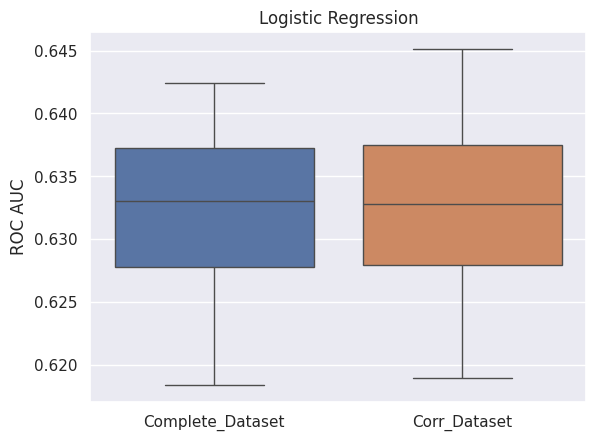

In [ ]:
sns.boxplot(comparativo_datasets_lr)
plt.ylabel('ROC AUC')
plt.title('Logistic Regression')

Resultados ligeiramente superiores com o dataset contendo as features selecionadas através da correlação.

# Tuning


Usar a biblioteca optuna para buscar os melhores parâmetros para o modelo

In [ ]:
def objective_lr(trial):
    params = {

        'C' : trial.suggest_loguniform("C", 1e-3, 1), # intensidade da regularização
        'penalty' : trial.suggest_categorical('penalty',['l1','l2']) # tipo de regularização
    }
    model = LogisticRegression(random_state=seed,max_iter=1000,solver='saga',**params)
    model.fit(x_train_tuning, y_train_tuning)
    roc_auc=roc_auc_score(y_val_tuning,model.predict_proba(x_val_tuning)[:,1])
    return roc_auc

In [ ]:
study_lr = optuna.create_study(direction='maximize')
study_lr.optimize(objective_lr, n_trials=50)

[I 2024-10-25 19:19:39,646] A new study created in memory with name: no-name-dbbe3f49-4b8e-4ab2-8a6b-ffda084a8244
<ipython-input-16-1571320f4e90>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C' : trial.suggest_loguniform("C", 1e-3, 1), # intensidade da regularização
[I 2024-10-25 19:26:50,063] Trial 0 finished with value: 0.6305728440750731 and parameters: {'C': 0.10652343484791704, 'penalty': 'l2'}. Best is trial 0 with value: 0.6305728440750731.
<ipython-input-16-1571320f4e90>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C' : trial.suggest_loguniform("C", 1e-3, 1), # intensidade da regularização
[I 2024-10-25 19:27:21,455] Trial 1 finished with value: 0.6290

In [ ]:
print('Melhores hiperparâmetros:', study_lr.best_params)
print('Melhor AUC:', study_lr.best_value)

Melhores hiperparâmetros: {'C': 0.01924040630345381, 'penalty': 'l2'}
Melhor AUC: 0.6307672969060888


In [ ]:
#Salvar melhores parâmetros
best_parameters_lr=study_lr.best_params
np.save(path+'/best_parameters_lr.npy', best_parameters_lr)

### Comparativo

In [ ]:
#carregar os melhores parâmetros encontrados
best_parameters_lr = np.load(path+'/best_parameters_lr.npy',allow_pickle='TRUE').item()


In [ ]:
#Treinar regressão logistica com parâmetros default e com os melhores parâmetros encontrados através do tuning

In [ ]:
#definição dos modelos
logistic_model_baseline                  = LogisticRegression(random_state=seed,solver='saga')
logistic_model_tuned_parameters = LogisticRegression(random_state=seed,solver='saga',**best_parameters_lr)

In [ ]:
resultados_default_lr = calcular_auc_stratifiedkfold(logistic_model_baseline, x_train_corr, y_train_corr, n_splits=10)
resultados_tuned_lr   = calcular_auc_stratifiedkfold(logistic_model_tuned_parameters, x_train_corr, y_train_corr, n_splits=10)

  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 10%|█         | 1/10 [01:27<13:05, 87.26s/it]/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 20%|██        | 2/10 [03:03<12:19, 92.43s/it]/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 30%|███       | 3/10 [04:30<10:29, 89.96s/it]/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 40%|████      | 4/10 [05:55<08:48, 88.06s/it]/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: Conv

In [ ]:
comparativo_default_tuned_lr = pd.DataFrame({'default':resultados_default_lr,
                                             'tuned':resultados_tuned_lr})

Text(0.5, 1.0, 'Logistic Regression')

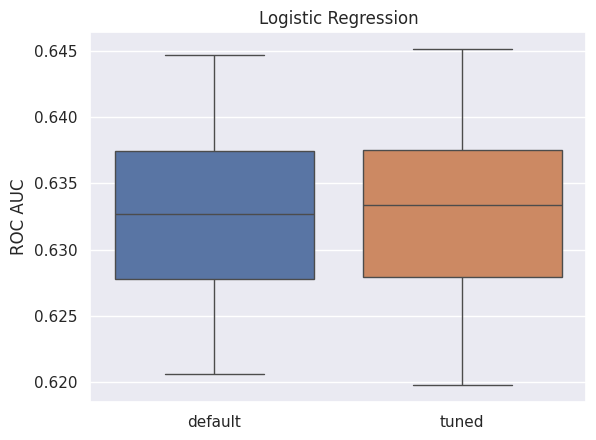

In [ ]:
sns.boxplot(comparativo_default_tuned_lr)
plt.ylabel('ROC AUC')
plt.title('Logistic Regression')

# LightGBM

Treinamento do modelo com parâmetros default para comparar os resultados com os dois datasets. O dataset que produzir os melhores resultados será usados nos passos seguintes.

## Comparativos dos datasets

In [ ]:
# definição do modelo
lgb_model=lgb.LGBMClassifier()

In [ ]:
# treinar modelo com  dataset completo
resultados_lgb_complete=calcular_auc_stratifiedkfold(lgb_model,x_train_complete,y_train_complete,n_splits=10)

  0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 13667, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.056633 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1385
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 132
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274769
[LightGBM] [Info] Start training from score -3.274769


 10%|█         | 1/10 [00:04<00:40,  4.45s/it]

[LightGBM] [Info] Number of positive: 13667, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.057808 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1379
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 132
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274769
[LightGBM] [Info] Start training from score -3.274769


 20%|██        | 2/10 [00:08<00:34,  4.31s/it]

[LightGBM] [Info] Number of positive: 13667, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.055945 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1383
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 132
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274769
[LightGBM] [Info] Start training from score -3.274769


 30%|███       | 3/10 [00:12<00:27,  3.90s/it]

[LightGBM] [Info] Number of positive: 13667, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.056196 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1385
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 132
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274769
[LightGBM] [Info] Start training from score -3.274769


 40%|████      | 4/10 [00:15<00:22,  3.71s/it]

[LightGBM] [Info] Number of positive: 13667, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.055112 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1382
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 132
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274769
[LightGBM] [Info] Start training from score -3.274769


 50%|█████     | 5/10 [00:18<00:18,  3.60s/it]

[LightGBM] [Info] Number of positive: 13667, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.080161 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1389
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 132
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274769
[LightGBM] [Info] Start training from score -3.274769


 60%|██████    | 6/10 [00:23<00:15,  3.81s/it]

[LightGBM] [Info] Number of positive: 13668, number of negative: 361315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.055735 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1385
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 132
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036450 -> initscore=-3.274693
[LightGBM] [Info] Start training from score -3.274693


 70%|███████   | 7/10 [00:26<00:11,  3.67s/it]

[LightGBM] [Info] Number of positive: 13668, number of negative: 361315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.055684 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1384
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 132
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036450 -> initscore=-3.274693
[LightGBM] [Info] Start training from score -3.274693


 80%|████████  | 8/10 [00:29<00:07,  3.57s/it]

[LightGBM] [Info] Number of positive: 13668, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.054227 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1384
[LightGBM] [Info] Number of data points in the train set: 374984, number of used features: 132
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036450 -> initscore=-3.274696
[LightGBM] [Info] Start training from score -3.274696


 90%|█████████ | 9/10 [00:33<00:03,  3.49s/it]

[LightGBM] [Info] Number of positive: 13668, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.081371 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1378
[LightGBM] [Info] Number of data points in the train set: 374984, number of used features: 132
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036450 -> initscore=-3.274696
[LightGBM] [Info] Start training from score -3.274696


100%|██████████| 10/10 [00:36<00:00,  3.69s/it]


In [ ]:
# treinar modelo usando o dataset com as features selecionadas através da correlação
resultados_lgb_corr=calcular_auc_stratifiedkfold(lgb_model,x_train_corr,y_train_corr,n_splits=10)

  0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 13667, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038213 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1187
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274769
[LightGBM] [Info] Start training from score -3.274769


 10%|█         | 1/10 [00:02<00:24,  2.73s/it]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 13667, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038139 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1181
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274769
[LightGBM] [Info] Start training from score -3.274769


 20%|██        | 2/10 [00:05<00:21,  2.69s/it]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 13667, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037314 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1186
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274769
[LightGBM] [Info] Start training from score -3.274769


 30%|███       | 3/10 [00:08<00:18,  2.67s/it]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 13667, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.054892 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1188
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274769
[LightGBM] [Info] Start training from score -3.274769


 40%|████      | 4/10 [00:11<00:17,  2.98s/it]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 13667, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037825 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1186
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274769
[LightGBM] [Info] Start training from score -3.274769


 50%|█████     | 5/10 [00:14<00:14,  2.88s/it]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 13667, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038157 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1191
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274769
[LightGBM] [Info] Start training from score -3.274769


 60%|██████    | 6/10 [00:16<00:11,  2.81s/it]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 13668, number of negative: 361315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.048669 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1186
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036450 -> initscore=-3.274693
[LightGBM] [Info] Start training from score -3.274693


 70%|███████   | 7/10 [00:19<00:08,  2.76s/it]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 13668, number of negative: 361315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037648 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1185
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036450 -> initscore=-3.274693
[LightGBM] [Info] Start training from score -3.274693


 80%|████████  | 8/10 [00:22<00:05,  2.83s/it]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 13668, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.055782 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1185
[LightGBM] [Info] Number of data points in the train set: 374984, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036450 -> initscore=-3.274696
[LightGBM] [Info] Start training from score -3.274696


 90%|█████████ | 9/10 [00:25<00:02,  2.87s/it]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 13668, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037384 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1181
[LightGBM] [Info] Number of data points in the train set: 374984, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036450 -> initscore=-3.274696
[LightGBM] [Info] Start training from score -3.274696


100%|██████████| 10/10 [00:28<00:00,  2.81s/it]


In [ ]:
comparativo_datasets_lgb=pd.DataFrame({'Complete_Dataset':resultados_lgb_complete,
                                      "Corr_Dataset":resultados_lgb_corr})

Text(0, 0.5, 'ROC AUC')

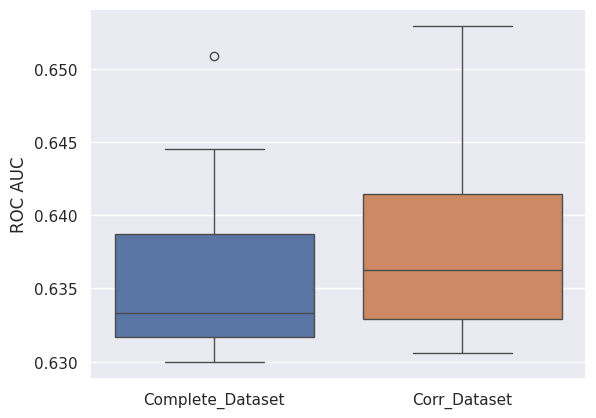

In [ ]:
sns.boxplot(comparativo_datasets_lgb)
plt.ylabel('ROC AUC')

## Tuning

Usar a biblioteca optuna para buscar os melhores parâmetros para o modelo.


Parâmetros para ajuste:

1. n_estimators - variar entre cem e mil;
2. learning rate - entre 0.001 e 0.1;
3. num_leaves - 2 até 1024, potências de 2. Auanto maior num_leaves, maior é a complexidade de cada árvore;
4. subsample - quantidade de dados usados na contrução de cada árvore do modelo, é uma fração que varia de 0 a 1.Testar intervalo entre 0.05 e 1. bagging_freq deve ser definido como um valor positivo ou o LightGBM ignorará o subsample;
4. colsample_bytree - determina a proporção de features a serem usadas para cada árvore. Testar intervalo entre 0.05 e 1;
5. min_data_in_leaf - define o número mínimo de pontos de dados que devem estar presentes em nós terminais de cada árvore. Testar intervalo entre 1 e 100.

In [ ]:
def objective_lgb(trial):
    params = {
        "metric": "auc",
        "n_estimators": trial.suggest_int('n_estimators',100,1000),
        "bagging_freq": 1,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 2**10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
    }
    model = lgb.LGBMClassifier(importance_type='gain',**params)
    model.fit(x_train_tuning, y_train_tuning)
    roc_auc=roc_auc_score(y_val_tuning,model.predict_proba(x_val_tuning)[:,1])
    return roc_auc

In [ ]:
study_lgb = optuna.create_study(direction='maximize')
study_lgb.optimize(objective_lgb, n_trials=50)

[I 2024-10-25 22:27:03,539] A new study created in memory with name: no-name-5a66a9aa-4068-47f3-8ea8-886733115a41


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 10225, number of negative: 268929
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056104 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1183
[LightGBM] [Info] Number of data points in the train set: 279154, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036629 -> initscore=-3.269612
[LightGBM] [Info]

[I 2024-10-25 22:27:21,672] Trial 0 finished with value: 0.6249889548793492 and parameters: {'n_estimators': 544, 'learning_rate': 0.007974884097087418, 'num_leaves': 834, 'subsample': 0.6342300030563526, 'colsample_bytree': 0.07293431163281562, 'min_data_in_leaf': 15}. Best is trial 0 with value: 0.6249889548793492.


[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=49
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=49
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 10225, number of negative: 268929
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030038 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1183
[LightGBM] [Info] Number of data points in the train set: 279154, number of used features: 108
[LightGBM] [Info] [binary:BoostFr

[I 2024-10-25 22:27:40,657] Trial 1 finished with value: 0.5974994444568763 and parameters: {'n_estimators': 843, 'learning_rate': 0.035600089430400036, 'num_leaves': 60, 'subsample': 0.17421854420951527, 'colsample_bytree': 0.852788525538643, 'min_data_in_leaf': 49}. Best is trial 0 with value: 0.6249889548793492.


[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 10225, number of negative: 268929
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027291 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1183
[LightGBM] [Info] Number of data points in the train set: 279154, number of used features: 108
[LightGBM] [Info] [binary:BoostFr

[I 2024-10-25 22:27:46,032] Trial 2 finished with value: 0.6349529392650661 and parameters: {'n_estimators': 147, 'learning_rate': 0.010402334710065386, 'num_leaves': 207, 'subsample': 0.9383261836167933, 'colsample_bytree': 0.45893279541606524, 'min_data_in_leaf': 53}. Best is trial 2 with value: 0.6349529392650661.


[LightGBM] [Warning] min_data_in_leaf is set=64, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=64
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=64, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=64
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 10225, number of negative: 268929
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029045 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1183
[LightGBM] [Info] Number of data points in the train set: 279154, number of used features: 108
[LightGBM] [Info] [binary:BoostFr

[I 2024-10-25 22:27:52,893] Trial 3 finished with value: 0.6326560606365044 and parameters: {'n_estimators': 407, 'learning_rate': 0.03928523803315325, 'num_leaves': 19, 'subsample': 0.18992342368867876, 'colsample_bytree': 0.8851452858049994, 'min_data_in_leaf': 64}. Best is trial 2 with value: 0.6349529392650661.


[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 10225, number of negative: 268929
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026579 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1183
[LightGBM] [Info] Number of data points in the train set: 279154, number of used features: 108
[LightGBM] [Info] [binary:BoostFr

[I 2024-10-25 22:28:05,461] Trial 4 finished with value: 0.6336197285443528 and parameters: {'n_estimators': 241, 'learning_rate': 0.0035084955946104546, 'num_leaves': 527, 'subsample': 0.18998863794826532, 'colsample_bytree': 0.42044414661026214, 'min_data_in_leaf': 42}. Best is trial 2 with value: 0.6349529392650661.


[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 10225, number of negative: 268929
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026024 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1183
[LightGBM] [Info] Number of data points in the train set: 279154, number of used features: 108
[LightGBM] [Info] [binary:BoostFromSc

[I 2024-10-25 22:28:18,032] Trial 5 finished with value: 0.6296888922157183 and parameters: {'n_estimators': 552, 'learning_rate': 0.020310948853321038, 'num_leaves': 115, 'subsample': 0.6913125634948278, 'colsample_bytree': 0.0587930845073186, 'min_data_in_leaf': 6}. Best is trial 2 with value: 0.6349529392650661.


[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 10225, number of negative: 268929
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040319 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1183
[LightGBM] [Info] Number of data points in the train set: 279154, number of used features: 108
[LightGBM] [Info] [binary:BoostFr

[I 2024-10-25 22:28:29,744] Trial 6 finished with value: 0.5921439520139107 and parameters: {'n_estimators': 344, 'learning_rate': 0.06581088542427227, 'num_leaves': 354, 'subsample': 0.807925233975407, 'colsample_bytree': 0.7507937867807912, 'min_data_in_leaf': 50}. Best is trial 2 with value: 0.6349529392650661.


[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 10225, number of negative: 268929
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039216 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1183
[LightGBM] [Info] Number of data points in the train set: 279154, number of used features: 108
[LightGBM] [Info] [binary:BoostFromSc

[I 2024-10-25 22:28:38,897] Trial 7 finished with value: 0.6304923675659254 and parameters: {'n_estimators': 186, 'learning_rate': 0.016635756540162812, 'num_leaves': 547, 'subsample': 0.8809013282991974, 'colsample_bytree': 0.44436116084000393, 'min_data_in_leaf': 7}. Best is trial 2 with value: 0.6349529392650661.


[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 10225, number of negative: 268929
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028259 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1183
[LightGBM] [Info] Number of data points in the train set: 279154, number of used features: 108
[LightGBM] [Info] [binary:BoostFr

[I 2024-10-25 22:28:58,557] Trial 8 finished with value: 0.578126461391497 and parameters: {'n_estimators': 543, 'learning_rate': 0.08700558988621825, 'num_leaves': 374, 'subsample': 0.7399731688958329, 'colsample_bytree': 0.6137205365906625, 'min_data_in_leaf': 36}. Best is trial 2 with value: 0.6349529392650661.


[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 10225, number of negative: 268929
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028694 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1183
[LightGBM] [Info] Number of data points in the train set: 279154, number of used features: 108
[LightGBM] [Info] [binary:BoostFr

[I 2024-10-25 22:29:54,855] Trial 9 finished with value: 0.6175497029060455 and parameters: {'n_estimators': 771, 'learning_rate': 0.009220304995236121, 'num_leaves': 910, 'subsample': 0.7842830157916523, 'colsample_bytree': 0.8088724933756746, 'min_data_in_leaf': 59}. Best is trial 2 with value: 0.6349529392650661.


[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 10225, number of negative: 268929
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026422 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1183
[LightGBM] [Info] Number of data points in the train set: 279154, number of used features: 108
[LightGBM] [Info] [binary:BoostFr

[I 2024-10-25 22:30:00,484] Trial 10 finished with value: 0.6300908154432214 and parameters: {'n_estimators': 103, 'learning_rate': 0.001085526961091005, 'num_leaves': 295, 'subsample': 0.4361809192575823, 'colsample_bytree': 0.2684344393077217, 'min_data_in_leaf': 98}. Best is trial 2 with value: 0.6349529392650661.


[LightGBM] [Warning] min_data_in_leaf is set=76, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=76
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=76, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=76
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 10225, number of negative: 268929
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028869 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1183
[LightGBM] [Info] Number of data points in the train set: 279154, number of used features: 108
[LightGBM] [Info] [binary:BoostFr

[I 2024-10-25 22:30:18,190] Trial 11 finished with value: 0.6345089853772283 and parameters: {'n_estimators': 274, 'learning_rate': 0.0037181913841228963, 'num_leaves': 619, 'subsample': 0.3909949847150023, 'colsample_bytree': 0.43303875002437126, 'min_data_in_leaf': 76}. Best is trial 2 with value: 0.6349529392650661.


[LightGBM] [Warning] min_data_in_leaf is set=75, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=75
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=75, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=75
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 10225, number of negative: 268929
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035544 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1183
[LightGBM] [Info] Number of data points in the train set: 279154, number of used features: 108
[LightGBM] [Info] [binary:BoostFr

[I 2024-10-25 22:30:37,825] Trial 12 finished with value: 0.6327638103065394 and parameters: {'n_estimators': 298, 'learning_rate': 0.0032541100598537424, 'num_leaves': 689, 'subsample': 0.42484489348705257, 'colsample_bytree': 0.2879366986780141, 'min_data_in_leaf': 75}. Best is trial 2 with value: 0.6349529392650661.


[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=87
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=87
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 10225, number of negative: 268929
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028794 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1183
[LightGBM] [Info] Number of data points in the train set: 279154, number of used features: 108
[LightGBM] [Info] [binary:BoostFr

[I 2024-10-25 22:30:45,143] Trial 13 finished with value: 0.6334051660918084 and parameters: {'n_estimators': 115, 'learning_rate': 0.003926604829556877, 'num_leaves': 687, 'subsample': 0.9555754023309366, 'colsample_bytree': 0.5985243328939197, 'min_data_in_leaf': 87}. Best is trial 2 with value: 0.6349529392650661.


[LightGBM] [Warning] min_data_in_leaf is set=74, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=74
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=74, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=74
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 10225, number of negative: 268929
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029202 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1183
[LightGBM] [Info] Number of data points in the train set: 279154, number of used features: 108
[LightGBM] [Info] [binary:BoostFr

[I 2024-10-25 22:31:01,363] Trial 14 finished with value: 0.6340485720789999 and parameters: {'n_estimators': 423, 'learning_rate': 0.0013494650683318536, 'num_leaves': 222, 'subsample': 0.3291852766286281, 'colsample_bytree': 0.29031580746011887, 'min_data_in_leaf': 74}. Best is trial 2 with value: 0.6349529392650661.


[LightGBM] [Warning] min_data_in_leaf is set=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 10225, number of negative: 268929
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027699 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1183
[LightGBM] [Info] Number of data points in the train set: 279154, number of used features: 108
[LightGBM] [Info] [binary:BoostFr

[I 2024-10-25 22:31:14,119] Trial 15 finished with value: 0.6326406019923343 and parameters: {'n_estimators': 230, 'learning_rate': 0.006314389419476724, 'num_leaves': 640, 'subsample': 0.5608904370711673, 'colsample_bytree': 0.479937063351144, 'min_data_in_leaf': 27}. Best is trial 2 with value: 0.6349529392650661.


[LightGBM] [Warning] min_data_in_leaf is set=71, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=71
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=71, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=71
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 10225, number of negative: 268929
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028736 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1183
[LightGBM] [Info] Number of data points in the train set: 279154, number of used features: 108
[LightGBM] [Info] [binary:BoostFr

[I 2024-10-25 22:32:09,006] Trial 16 finished with value: 0.6338360613492994 and parameters: {'n_estimators': 963, 'learning_rate': 0.002141420171863024, 'num_leaves': 441, 'subsample': 0.3275169400044306, 'colsample_bytree': 0.9905749394373047, 'min_data_in_leaf': 71}. Best is trial 2 with value: 0.6349529392650661.


[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 10225, number of negative: 268929
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028148 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1183
[LightGBM] [Info] Number of data points in the train set: 279154, number of used features: 108
[LightGBM] [Info] [binary:BoostFr

[I 2024-10-25 22:32:21,656] Trial 17 finished with value: 0.6256569541640843 and parameters: {'n_estimators': 443, 'learning_rate': 0.015183291266872222, 'num_leaves': 186, 'subsample': 0.05008430008011738, 'colsample_bytree': 0.6708459986135871, 'min_data_in_leaf': 92}. Best is trial 2 with value: 0.6349529392650661.


[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 10225, number of negative: 268929
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026523 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1183
[LightGBM] [Info] Number of data points in the train set: 279154, number of used features: 108
[LightGBM] [Info] [binary:BoostFr

[I 2024-10-25 22:33:16,597] Trial 18 finished with value: 0.6283347414504423 and parameters: {'n_estimators': 702, 'learning_rate': 0.006046429601826495, 'num_leaves': 1005, 'subsample': 0.9981733853229386, 'colsample_bytree': 0.389245188825442, 'min_data_in_leaf': 82}. Best is trial 2 with value: 0.6349529392650661.


[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=63
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=63
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 10225, number of negative: 268929
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025413 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1183
[LightGBM] [Info] Number of data points in the train set: 279154, number of used features: 108
[LightGBM] [Info] [binary:BoostFr

[I 2024-10-25 22:33:36,032] Trial 19 finished with value: 0.6281566354816404 and parameters: {'n_estimators': 314, 'learning_rate': 0.0017461824867832083, 'num_leaves': 829, 'subsample': 0.5379271040561773, 'colsample_bytree': 0.18393853187290152, 'min_data_in_leaf': 63}. Best is trial 2 with value: 0.6349529392650661.


[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 10225, number of negative: 268929
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030788 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1183
[LightGBM] [Info] Number of data points in the train set: 279154, number of used features: 108
[LightGBM] [Info] [binary:BoostFr

[I 2024-10-25 22:33:46,488] Trial 20 finished with value: 0.6275751811820701 and parameters: {'n_estimators': 166, 'learning_rate': 0.013176110516532025, 'num_leaves': 610, 'subsample': 0.4538451087780849, 'colsample_bytree': 0.5440008634882154, 'min_data_in_leaf': 24}. Best is trial 2 with value: 0.6349529392650661.


[LightGBM] [Warning] min_data_in_leaf is set=79, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=79
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=79, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=79
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 10225, number of negative: 268929
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026854 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1183
[LightGBM] [Info] Number of data points in the train set: 279154, number of used features: 108
[LightGBM] [Info] [binary:BoostFr

[I 2024-10-25 22:34:02,782] Trial 21 finished with value: 0.6352781396172087 and parameters: {'n_estimators': 407, 'learning_rate': 0.0019381468742189893, 'num_leaves': 227, 'subsample': 0.3546909780395813, 'colsample_bytree': 0.31645904445261697, 'min_data_in_leaf': 79}. Best is trial 21 with value: 0.6352781396172087.


[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 10225, number of negative: 268929
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026388 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1183
[LightGBM] [Info] Number of data points in the train set: 279154, number of used features: 108
[LightGBM] [Info] [binary:BoostFr

[I 2024-10-25 22:34:13,411] Trial 22 finished with value: 0.6338431488425926 and parameters: {'n_estimators': 262, 'learning_rate': 0.0023788277543755477, 'num_leaves': 234, 'subsample': 0.3020943315238563, 'colsample_bytree': 0.3588854280325303, 'min_data_in_leaf': 82}. Best is trial 21 with value: 0.6352781396172087.


[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=56
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=56
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 10225, number of negative: 268929
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025034 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1183
[LightGBM] [Info] Number of data points in the train set: 279154, number of used features: 108
[LightGBM] [Info] [binary:BoostFr

[I 2024-10-25 22:34:35,889] Trial 23 finished with value: 0.6312774641030517 and parameters: {'n_estimators': 461, 'learning_rate': 0.005129963498348328, 'num_leaves': 433, 'subsample': 0.6396271084156786, 'colsample_bytree': 0.1811110871224661, 'min_data_in_leaf': 56}. Best is trial 21 with value: 0.6352781396172087.


[LightGBM] [Warning] min_data_in_leaf is set=69, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=69
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=69, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=69
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 10225, number of negative: 268929
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027781 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1183
[LightGBM] [Info] Number of data points in the train set: 279154, number of used features: 108
[LightGBM] [Info] [binary:BoostFr

[I 2024-10-25 22:34:48,137] Trial 24 finished with value: 0.6357350198152396 and parameters: {'n_estimators': 356, 'learning_rate': 0.0026477839184792097, 'num_leaves': 181, 'subsample': 0.2631479625494405, 'colsample_bytree': 0.5169252321905163, 'min_data_in_leaf': 69}. Best is trial 24 with value: 0.6357350198152396.


[LightGBM] [Warning] min_data_in_leaf is set=67, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=67
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=67, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=67
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 10225, number of negative: 268929
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030007 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1183
[LightGBM] [Info] Number of data points in the train set: 279154, number of used features: 108
[LightGBM] [Info] [binary:BoostFr

[I 2024-10-25 22:35:09,588] Trial 25 finished with value: 0.6357568997891704 and parameters: {'n_estimators': 621, 'learning_rate': 0.001765294109595684, 'num_leaves': 170, 'subsample': 0.25875545318026505, 'colsample_bytree': 0.5754804679150293, 'min_data_in_leaf': 67}. Best is trial 25 with value: 0.6357568997891704.


[LightGBM] [Warning] min_data_in_leaf is set=68, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=68
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=68, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=68
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 10225, number of negative: 268929
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028506 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1183
[LightGBM] [Info] Number of data points in the train set: 279154, number of used features: 108
[LightGBM] [Info] [binary:BoostFr

[I 2024-10-25 22:35:28,306] Trial 26 finished with value: 0.6342876152809112 and parameters: {'n_estimators': 661, 'learning_rate': 0.001545876935327085, 'num_leaves': 92, 'subsample': 0.24451890739530052, 'colsample_bytree': 0.7092196722251166, 'min_data_in_leaf': 68}. Best is trial 25 with value: 0.6357568997891704.


[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 10225, number of negative: 268929
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027528 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1183
[LightGBM] [Info] Number of data points in the train set: 279154, number of used features: 108
[LightGBM] [Info] [binary:BoostFr

[I 2024-10-25 22:35:47,591] Trial 27 finished with value: 0.6336684132354082 and parameters: {'n_estimators': 629, 'learning_rate': 0.0010331236820124655, 'num_leaves': 147, 'subsample': 0.0793787530783869, 'colsample_bytree': 0.5365758360530712, 'min_data_in_leaf': 99}. Best is trial 25 with value: 0.6357568997891704.


[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=83
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=83
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 10225, number of negative: 268929
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028151 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1183
[LightGBM] [Info] Number of data points in the train set: 279154, number of used features: 108
[LightGBM] [Info] [binary:BoostFr

[I 2024-10-25 22:36:03,623] Trial 28 finished with value: 0.6345193884789722 and parameters: {'n_estimators': 367, 'learning_rate': 0.0026484530761495596, 'num_leaves': 316, 'subsample': 0.12772996637935313, 'colsample_bytree': 0.635054258611977, 'min_data_in_leaf': 83}. Best is trial 25 with value: 0.6357568997891704.


[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 10225, number of negative: 268929
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024975 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1183
[LightGBM] [Info] Number of data points in the train set: 279154, number of used features: 108
[LightGBM] [Info] [binary:BoostFr

[I 2024-10-25 22:36:12,892] Trial 29 finished with value: 0.6257279857519118 and parameters: {'n_estimators': 536, 'learning_rate': 0.0018489598691711071, 'num_leaves': 13, 'subsample': 0.2521164581693274, 'colsample_bytree': 0.13333443838006925, 'min_data_in_leaf': 91}. Best is trial 25 with value: 0.6357568997891704.


[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 10225, number of negative: 268929
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025745 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1183
[LightGBM] [Info] Number of data points in the train set: 279154, number of used features: 108
[LightGBM] [Info] [binary:BoostFr

[I 2024-10-25 22:36:34,296] Trial 30 finished with value: 0.635777305990354 and parameters: {'n_estimators': 507, 'learning_rate': 0.002679123885651409, 'num_leaves': 276, 'subsample': 0.36939883030740067, 'colsample_bytree': 0.36304224503289684, 'min_data_in_leaf': 43}. Best is trial 30 with value: 0.635777305990354.


[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 10225, number of negative: 268929
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039704 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1183
[LightGBM] [Info] Number of data points in the train set: 279154, number of used features: 108
[LightGBM] [Info] [binary:BoostFr

[I 2024-10-25 22:36:55,663] Trial 31 finished with value: 0.6356063985421008 and parameters: {'n_estimators': 497, 'learning_rate': 0.0026207692782244186, 'num_leaves': 275, 'subsample': 0.3716133596801359, 'colsample_bytree': 0.5115448107721056, 'min_data_in_leaf': 42}. Best is trial 30 with value: 0.635777305990354.


[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 10225, number of negative: 268929
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027627 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1183
[LightGBM] [Info] Number of data points in the train set: 279154, number of used features: 108
[LightGBM] [Info] [binary:BoostFr

[I 2024-10-25 22:37:16,007] Trial 32 finished with value: 0.6353055009915319 and parameters: {'n_estimators': 483, 'learning_rate': 0.004627770757612428, 'num_leaves': 284, 'subsample': 0.2612870372469639, 'colsample_bytree': 0.5317335125488287, 'min_data_in_leaf': 43}. Best is trial 30 with value: 0.635777305990354.


[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 10225, number of negative: 268929
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027690 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1183
[LightGBM] [Info] Number of data points in the train set: 279154, number of used features: 108
[LightGBM] [Info] [binary:BoostFr

[I 2024-10-25 22:37:37,386] Trial 33 finished with value: 0.6362004141307502 and parameters: {'n_estimators': 593, 'learning_rate': 0.0026838758699680855, 'num_leaves': 154, 'subsample': 0.4883916793930307, 'colsample_bytree': 0.4869835411689947, 'min_data_in_leaf': 33}. Best is trial 33 with value: 0.6362004141307502.


[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 10225, number of negative: 268929
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027835 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1183
[LightGBM] [Info] Number of data points in the train set: 279154, number of used features: 108
[LightGBM] [Info] [binary:BoostFr

[I 2024-10-25 22:38:00,194] Trial 34 finished with value: 0.6341879569122324 and parameters: {'n_estimators': 620, 'learning_rate': 0.0013934392054857114, 'num_leaves': 136, 'subsample': 0.4977687753097996, 'colsample_bytree': 0.5791936198827881, 'min_data_in_leaf': 30}. Best is trial 33 with value: 0.6362004141307502.


[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 10225, number of negative: 268929
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025704 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1183
[LightGBM] [Info] Number of data points in the train set: 279154, number of used features: 108
[LightGBM] [Info] [binary:BoostFr

[I 2024-10-25 22:38:16,096] Trial 35 finished with value: 0.6339561061471847 and parameters: {'n_estimators': 592, 'learning_rate': 0.0028144327166491527, 'num_leaves': 66, 'subsample': 0.6093437219008596, 'colsample_bytree': 0.3576647748843688, 'min_data_in_leaf': 19}. Best is trial 33 with value: 0.6362004141307502.


[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 10225, number of negative: 268929
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027948 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1183
[LightGBM] [Info] Number of data points in the train set: 279154, number of used features: 108
[LightGBM] [Info] [binary:BoostFr

[I 2024-10-25 22:38:40,305] Trial 36 finished with value: 0.6310193318178092 and parameters: {'n_estimators': 749, 'learning_rate': 0.008008884233206266, 'num_leaves': 174, 'subsample': 0.16999716440279067, 'colsample_bytree': 0.47319010375424986, 'min_data_in_leaf': 35}. Best is trial 33 with value: 0.6362004141307502.


[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 10225, number of negative: 268929
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028328 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1183
[LightGBM] [Info] Number of data points in the train set: 279154, number of used features: 108
[LightGBM] [Info] [binary:BoostFr

[I 2024-10-25 22:39:25,595] Trial 37 finished with value: 0.5957247087596533 and parameters: {'n_estimators': 856, 'learning_rate': 0.024912966926346328, 'num_leaves': 406, 'subsample': 0.4923616410916333, 'colsample_bytree': 0.6807230521695724, 'min_data_in_leaf': 47}. Best is trial 33 with value: 0.6362004141307502.


[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=63
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=63
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 10225, number of negative: 268929
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028621 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1183
[LightGBM] [Info] Number of data points in the train set: 279154, number of used features: 108
[LightGBM] [Info] [binary:BoostFr

[I 2024-10-25 22:39:38,872] Trial 38 finished with value: 0.6354715582217353 and parameters: {'n_estimators': 566, 'learning_rate': 0.0045608891028395045, 'num_leaves': 65, 'subsample': 0.1895230451694524, 'colsample_bytree': 0.7482725037269968, 'min_data_in_leaf': 63}. Best is trial 33 with value: 0.6362004141307502.


[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 10225, number of negative: 268929
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026442 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1183
[LightGBM] [Info] Number of data points in the train set: 279154, number of used features: 108
[LightGBM] [Info] [binary:BoostFr

[I 2024-10-25 22:40:06,735] Trial 39 finished with value: 0.6336295171938884 and parameters: {'n_estimators': 497, 'learning_rate': 0.0063312788638584545, 'num_leaves': 489, 'subsample': 0.2966484926555135, 'colsample_bytree': 0.390905206848823, 'min_data_in_leaf': 53}. Best is trial 33 with value: 0.6362004141307502.


[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 10225, number of negative: 268929
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028654 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1183
[LightGBM] [Info] Number of data points in the train set: 279154, number of used features: 108
[LightGBM] [Info] [binary:BoostFr

[I 2024-10-25 22:40:23,359] Trial 40 finished with value: 0.6349828557871862 and parameters: {'n_estimators': 362, 'learning_rate': 0.003194761787534555, 'num_leaves': 338, 'subsample': 0.40346501673828866, 'colsample_bytree': 0.4919437823389115, 'min_data_in_leaf': 33}. Best is trial 33 with value: 0.6362004141307502.


[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 10225, number of negative: 268929
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065577 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1183
[LightGBM] [Info] Number of data points in the train set: 279154, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036629 -> initscore=-3.269612
[LightGBM] [Info]

[I 2024-10-25 22:40:39,095] Trial 41 finished with value: 0.6357699249592483 and parameters: {'n_estimators': 510, 'learning_rate': 0.0024218817350633434, 'num_leaves': 135, 'subsample': 0.22986504679750203, 'colsample_bytree': 0.5002089134317926, 'min_data_in_leaf': 40}. Best is trial 33 with value: 0.6362004141307502.


[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=48
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=48
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 10225, number of negative: 268929
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028105 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1183
[LightGBM] [Info] Number of data points in the train set: 279154, number of used features: 108
[LightGBM] [Info] [binary:BoostFr

[I 2024-10-25 22:40:57,942] Trial 42 finished with value: 0.6346871278481417 and parameters: {'n_estimators': 660, 'learning_rate': 0.001316873809541869, 'num_leaves': 114, 'subsample': 0.22051426250382594, 'colsample_bytree': 0.561452661331259, 'min_data_in_leaf': 48}. Best is trial 33 with value: 0.6362004141307502.


[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 10225, number of negative: 268929
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026178 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1183
[LightGBM] [Info] Number of data points in the train set: 279154, number of used features: 108
[LightGBM] [Info] [binary:BoostFr

[I 2024-10-25 22:41:05,436] Trial 43 finished with value: 0.6284870069662287 and parameters: {'n_estimators': 524, 'learning_rate': 0.0022913274590438118, 'num_leaves': 13, 'subsample': 0.148063291148211, 'colsample_bytree': 0.4296331248062634, 'min_data_in_leaf': 14}. Best is trial 33 with value: 0.6362004141307502.


[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=37
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=37
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 10225, number of negative: 268929
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038955 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1183
[LightGBM] [Info] Number of data points in the train set: 279154, number of used features: 108
[LightGBM] [Info] [binary:BoostFr

[I 2024-10-25 22:41:28,057] Trial 44 finished with value: 0.635602532360137 and parameters: {'n_estimators': 702, 'learning_rate': 0.0016621039873504198, 'num_leaves': 151, 'subsample': 0.28079626764656995, 'colsample_bytree': 0.6207346780865801, 'min_data_in_leaf': 37}. Best is trial 33 with value: 0.6362004141307502.


[LightGBM] [Warning] min_data_in_leaf is set=57, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=57
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=57, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=57
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 10225, number of negative: 268929
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027322 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1183
[LightGBM] [Info] Number of data points in the train set: 279154, number of used features: 108
[LightGBM] [Info] [binary:BoostFr

[I 2024-10-25 22:41:51,059] Trial 45 finished with value: 0.6358507162991067 and parameters: {'n_estimators': 567, 'learning_rate': 0.0037597630435763766, 'num_leaves': 253, 'subsample': 0.21878702680680234, 'colsample_bytree': 0.44780722199219325, 'min_data_in_leaf': 57}. Best is trial 33 with value: 0.6362004141307502.


[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 10225, number of negative: 268929
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027314 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1183
[LightGBM] [Info] Number of data points in the train set: 279154, number of used features: 108
[LightGBM] [Info] [binary:BoostFr

[I 2024-10-25 22:42:15,437] Trial 46 finished with value: 0.6352242107894849 and parameters: {'n_estimators': 579, 'learning_rate': 0.0035822847159115603, 'num_leaves': 246, 'subsample': 0.44981172237748523, 'colsample_bytree': 0.22233408891377604, 'min_data_in_leaf': 59}. Best is trial 33 with value: 0.6362004141307502.


[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 10225, number of negative: 268929
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025596 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1183
[LightGBM] [Info] Number of data points in the train set: 279154, number of used features: 108
[LightGBM] [Info] [binary:BoostFr

[I 2024-10-25 22:42:43,477] Trial 47 finished with value: 0.5744833529558291 and parameters: {'n_estimators': 611, 'learning_rate': 0.04258133570909134, 'num_leaves': 377, 'subsample': 0.11186112136963361, 'colsample_bytree': 0.34755792483601344, 'min_data_in_leaf': 42}. Best is trial 33 with value: 0.6362004141307502.


[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 10225, number of negative: 268929
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027076 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1183
[LightGBM] [Info] Number of data points in the train set: 279154, number of used features: 108
[LightGBM] [Info] [binary:BoostFr

[I 2024-10-25 22:43:03,171] Trial 48 finished with value: 0.6373045147866121 and parameters: {'n_estimators': 803, 'learning_rate': 0.004110353481246674, 'num_leaves': 72, 'subsample': 0.2102013060024204, 'colsample_bytree': 0.4504280489268808, 'min_data_in_leaf': 45}. Best is trial 48 with value: 0.6373045147866121.


[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 10225, number of negative: 268929
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038696 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1183
[LightGBM] [Info] Number of data points in the train set: 279154, number of used features: 108
[LightGBM] [Info] [binary:BoostFr

[I 2024-10-25 22:43:24,278] Trial 49 finished with value: 0.6377941115228902 and parameters: {'n_estimators': 813, 'learning_rate': 0.004016609229734623, 'num_leaves': 86, 'subsample': 0.19892371972444625, 'colsample_bytree': 0.41369994989274667, 'min_data_in_leaf': 52}. Best is trial 49 with value: 0.6377941115228902.


In [ ]:
print('Melhores hiperparâmetros:', study_lgb.best_params)
print('Melhor AUC:', study_lgb.best_value)

Melhores hiperparâmetros: {'n_estimators': 813, 'learning_rate': 0.004016609229734623, 'num_leaves': 86, 'subsample': 0.19892371972444625, 'colsample_bytree': 0.41369994989274667, 'min_data_in_leaf': 52}
Melhor AUC: 0.6377941115228902


In [ ]:
#Salvar melhores parâmetros
best_parameters_lgb=study_lgb.best_params
np.save(path+'/best_parameters_lgb.npy', best_parameters_lgb)

### Comparativo

In [ ]:
#carregar os melhores parâmetros encontrados
best_parameters_lgb = np.load(path+'/best_parameters_lgb.npy',allow_pickle='TRUE').item()


In [ ]:
#Treinar LightGBM com parâmetros default e com os melhores parâmetros encontrados através do tuning

In [ ]:
# definição dos modelos

lgb_baseline = lgb.LGBMClassifier(importance_type='gain')
lgb_tuned    = lgb.LGBMClassifier(importance_type='gain',**best_parameters_lgb)


In [ ]:
resultados_default_lgb = calcular_auc_stratifiedkfold(lgb_baseline, x_train_corr, y_train_corr, n_splits=10)
resultados_tuned_lgb   = calcular_auc_stratifiedkfold(lgb_tuned, x_train_corr, y_train_corr, n_splits=10)

  0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 13667, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038094 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1187
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274769
[LightGBM] [Info] Start training from score -3.274769


 10%|█         | 1/10 [00:02<00:24,  2.75s/it]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 13667, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037986 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1181
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274769
[LightGBM] [Info] Start training from score -3.274769


 20%|██        | 2/10 [00:05<00:21,  2.69s/it]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 13667, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038488 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1186
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274769
[LightGBM] [Info] Start training from score -3.274769


 30%|███       | 3/10 [00:08<00:18,  2.69s/it]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 13667, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.051072 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1188
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274769
[LightGBM] [Info] Start training from score -3.274769


 40%|████      | 4/10 [00:11<00:17,  2.91s/it]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 13667, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037821 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1186
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274769
[LightGBM] [Info] Start training from score -3.274769


 50%|█████     | 5/10 [00:14<00:14,  2.84s/it]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 13667, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037662 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1191
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274769
[LightGBM] [Info] Start training from score -3.274769


 60%|██████    | 6/10 [00:16<00:11,  2.77s/it]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 13668, number of negative: 361315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.042216 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1186
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036450 -> initscore=-3.274693
[LightGBM] [Info] Start training from score -3.274693


 70%|███████   | 7/10 [00:19<00:08,  2.74s/it]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 13668, number of negative: 361315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037260 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1185
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036450 -> initscore=-3.274693
[LightGBM] [Info] Start training from score -3.274693


 80%|████████  | 8/10 [00:22<00:05,  2.79s/it]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 13668, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043846 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1185
[LightGBM] [Info] Number of data points in the train set: 374984, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036450 -> initscore=-3.274696
[LightGBM] [Info] Start training from score -3.274696


 90%|█████████ | 9/10 [00:25<00:02,  2.86s/it]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 13668, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037599 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1181
[LightGBM] [Info] Number of data points in the train set: 374984, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036450 -> initscore=-3.274696
[LightGBM] [Info] Start training from score -3.274696


  0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Info] Number of positive: 13667, number of negative: 361316
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072153 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1187
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274769
[LightGBM] [Info] Start training from score -3.274769
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52


 10%|█         | 1/10 [00:25<03:47, 25.32s/it]

[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Info] Number of positive: 13667, number of negative: 361316
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071385 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1181
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274769
[LightGBM] [Info] Start training from score -3.274769
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52


 20%|██        | 2/10 [00:49<03:18, 24.87s/it]

[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Info] Number of positive: 13667, number of negative: 361316
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1186
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274769
[LightGBM] [Info] Start training from score -3.274769
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52


 30%|███       | 3/10 [01:14<02:51, 24.55s/it]

[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Info] Number of positive: 13667, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.048349 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1188
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274769
[LightGBM] [Info] Start training from score -3.274769
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_l

 40%|████      | 4/10 [01:38<02:28, 24.68s/it]

[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Info] Number of positive: 13667, number of negative: 361316
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075900 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1186
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274769
[LightGBM] [Info] Start training from score -3.274769
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52


 50%|█████     | 5/10 [02:04<02:04, 24.93s/it]

[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Info] Number of positive: 13667, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034637 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1191
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274769
[LightGBM] [Info] Start training from score -3.274769
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_l

 60%|██████    | 6/10 [02:29<01:39, 24.95s/it]

[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Info] Number of positive: 13668, number of negative: 361315
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071424 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1186
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036450 -> initscore=-3.274693
[LightGBM] [Info] Start training from score -3.274693
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52


 70%|███████   | 7/10 [02:54<01:14, 24.98s/it]

[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Info] Number of positive: 13668, number of negative: 361315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034153 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1185
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036450 -> initscore=-3.274693
[LightGBM] [Info] Start training from score -3.274693
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_l

 80%|████████  | 8/10 [03:18<00:49, 24.68s/it]

[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Info] Number of positive: 13668, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.045824 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1185
[LightGBM] [Info] Number of data points in the train set: 374984, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036450 -> initscore=-3.274696
[LightGBM] [Info] Start training from score -3.274696
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_l

 90%|█████████ | 9/10 [03:42<00:24, 24.55s/it]

[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Info] Number of positive: 13668, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035641 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1181
[LightGBM] [Info] Number of data points in the train set: 374984, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036450 -> initscore=-3.274696
[LightGBM] [Info] Start training from score -3.274696
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_l

100%|██████████| 10/10 [04:07<00:00, 24.74s/it]


In [ ]:
comparativo_default_tuned_lgb = pd.DataFrame({'default':resultados_default_lgb,
                                             'tuned':   resultados_tuned_lgb})

Text(0, 0.5, 'ROC AUC')

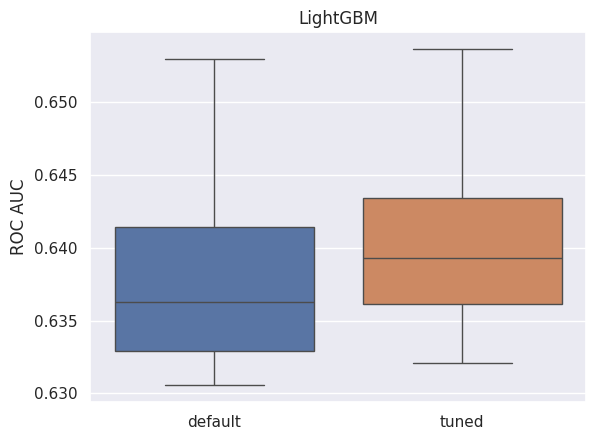

In [ ]:
sns.boxplot(comparativo_default_tuned_lgb)
plt.title('LightGBM')
plt.ylabel('ROC AUC')

# Comparativo Modelos

In [ ]:
comparativo_modelos=pd.DataFrame({'Logistic Regression': resultados_tuned_lr,
                                  'LightGBM': resultados_tuned_lgb })

Text(0, 0.5, 'ROC AUC')

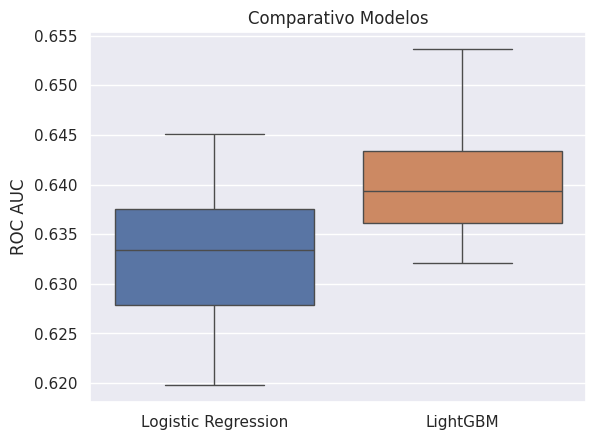

In [ ]:
sns.boxplot(comparativo_modelos)
plt.title("Comparativo Modelos")
plt.ylabel('ROC AUC')